# TCGA-UCEC – Notebook 0C
## Preprocessing Machine Learning : Target Engineering & Feature Selection

**Question de recherche** : Peut-on prédire l'évolution clinique (survie) d'une patiente à partir de son profil transcriptomique ?

**Objectifs** :
1. **Target Engineering** : Créer la variable cible `clinical_evolution` (Overall Survival à 5 ans).
2. **Data Quality Audit** : Vérifier la complétude et la distribution des données.
3. **Signal Assessment** : Évaluer la séparabilité transcriptomique entre Survived/Deceased.
4. **Feature Selection** : Préparer deux pipelines parallèles (Supervisé & Non-Supervisé).
5. **Export ML-ready** : Datasets finaux pour MLP (supervisé) et Autoencoder (non-supervisé).

### 1. Configuration et Environnement

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.manifold import TSNE
import umap
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

PROJECT_ROOT = os.getcwd()

DIRS = {
    "RAW": os.path.join(PROJECT_ROOT, "data", "raw"),
    "PROCESSED": os.path.join(PROJECT_ROOT, "data", "processed"),
    "NORM": os.path.join(PROJECT_ROOT, "data", "processed", "normalized"),
    "ML_READY": os.path.join(PROJECT_ROOT, "data", "processed", "ml_ready"),
    "SURVIVAL": os.path.join(PROJECT_ROOT, "data", "artefacts", "survival_analysis"),
    "FEATURES": os.path.join(PROJECT_ROOT, "data", "artefacts", "feature_selection")
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)

plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
sns.set_theme(style="whitegrid")

print(f"✅ Environnement chargé. Racine : {PROJECT_ROOT}")

✅ Environnement chargé. Racine : c:\Z\M2_AIDA\TCGA_UCEC_project


### 2. Chargement des données

In [38]:
df_expr = pd.read_csv(os.path.join(DIRS['NORM'], 'expr_norm_filtered.csv.gz'), 
                      index_col=0, compression='gzip')

df_clin = pd.read_csv(os.path.join(DIRS['RAW'], 'metadata_clinical_merged.csv.gz'), 
                      index_col=0, compression='gzip')

print(f"✅ Données chargées :")
print(f"   Expression : {df_expr.shape[0]} échantillons × {df_expr.shape[1]} gènes")
print(f"   Clinique   : {df_clin.shape[0]} échantillons × {df_clin.shape[1]} variables")

✅ Données chargées :
   Expression : 553 échantillons × 21168 gènes
   Clinique   : 553 échantillons × 175 variables


### 3. Target Engineering : Clinical Evolution (Overall Survival)

**Justification méthodologique** :
- Définition de la survie globale (OS) à 5 ans comme marqueur de substitution de l'évolution clinique <i>(Endpoint)</i>.
- Exclusion des données censurées <i>(Censored Data)</i>, i.e. suivi < 5 ans pour les patientes vivantes, afin d'éviter les biais.
- Utilisation de `vital_status.y` (statut vital) et `days_to_death.y` / `days_to_last_follow_up.y` (temps).

**Classes** :
- `Survived` : Patientes vivantes avec suivi ≥ 5 ans OU décédées après 5 ans.
- `Deceased` : Patientes décédées avant 5 ans.
- `Censored` : Patientes vivantes avec suivi < 5 ans (exclues de l'analyse ML).

**Choix du seuil temporel** : Après analyse de sensibilité des deux cut-offs (3 ans : n=283, 5 ans : n=196), le seuil à **5 ans** est retenu :

1. **Équilibre des classes** : 57% Survived / 43% Deceased (vs 74%/26% à 3 ans) → évite le biais de classe majoritaire sans nécessiter de rééchantillonnage.
2. **Standard clinique** : Le seuil à 5 ans est la référence établie dans la littérature oncologique pour évaluer le pronostic des cancers de l'endomètre [TCGA, 2013].
3. **Compensation du faible N** : Ratio features/observations défavorable (p/n = 15.3). <Br>Stratégie de dimensionnalité : 
  <Br>- Supervisé (MLP) : Réduction à 1000 gènes ciblés pour éviter l'overfitting (n=196).
  <Br>- Non-Supervisé (Autoencoder) : Réduction à 3000 gènes pour laisser le réseau découvrir les relations complexes sur la cohorte complète (n=553).

In [39]:
CUTOFF_DAYS = 1825

def create_survival_target(row):  
    vital = row['vital_status.y']
    days_death = row['days_to_death.y']
    days_followup = row['days_to_last_follow_up.y']
    
    if vital == 'Dead' and pd.notna(days_death):
        return 'Deceased' if days_death < CUTOFF_DAYS else 'Survived'
    elif vital == 'Alive' and pd.notna(days_followup):
        return 'Survived' if days_followup >= CUTOFF_DAYS else 'Censored'
    return 'Unknown'

df_clin['clinical_evolution'] = df_clin.apply(create_survival_target, axis=1)

print("\n" + "="*60)
print("DISTRIBUTION : CLINICAL EVOLUTION (OS à 5 ans)")
print("="*60)

counts = df_clin['clinical_evolution'].value_counts()
total = len(df_clin)

for cat in ['Survived', 'Deceased', 'Censored', 'Unknown']:
    n = counts.get(cat, 0)
    pct = (n / total) * 100
    print(f"{cat:12} : n={n:3} ({pct:5.1f}%)")

print(f"\nTOTAL        : n={total}")


DISTRIBUTION : CLINICAL EVOLUTION (OS à 5 ans)
Survived     : n=111 ( 20.1%)
Deceased     : n= 85 ( 15.4%)
Censored     : n=356 ( 64.4%)
Unknown      : n=  1 (  0.2%)

TOTAL        : n=553


### 4. Data Quality Audit

In [40]:
df_clin_clean = df_clin[df_clin['clinical_evolution'].isin(['Survived', 'Deceased'])].copy()

common_samples = df_clin_clean.index.intersection(df_expr.index)
df_clin_clean = df_clin_clean.loc[common_samples]
df_expr_clean = df_expr.loc[common_samples]

print("\n" + "="*60)
print("DATASET FINAL (après filtrage et alignement)")
print("="*60)

final_counts = df_clin_clean['clinical_evolution'].value_counts()
n_total = len(df_clin_clean)

for cat in ['Survived', 'Deceased']:
    n = final_counts.get(cat, 0)
    pct = (n / n_total) * 100
    print(f"{cat:12} : n={n:3} ({pct:5.1f}%)")

print(f"\nTOTAL UTILISABLE : n={n_total}")
print(f"Expression       : {df_expr_clean.shape[0]} échantillons × {df_expr_clean.shape[1]} gènes")


DATASET FINAL (après filtrage et alignement)
Survived     : n=111 ( 56.6%)
Deceased     : n= 85 ( 43.4%)

TOTAL UTILISABLE : n=196
Expression       : 196 échantillons × 21168 gènes


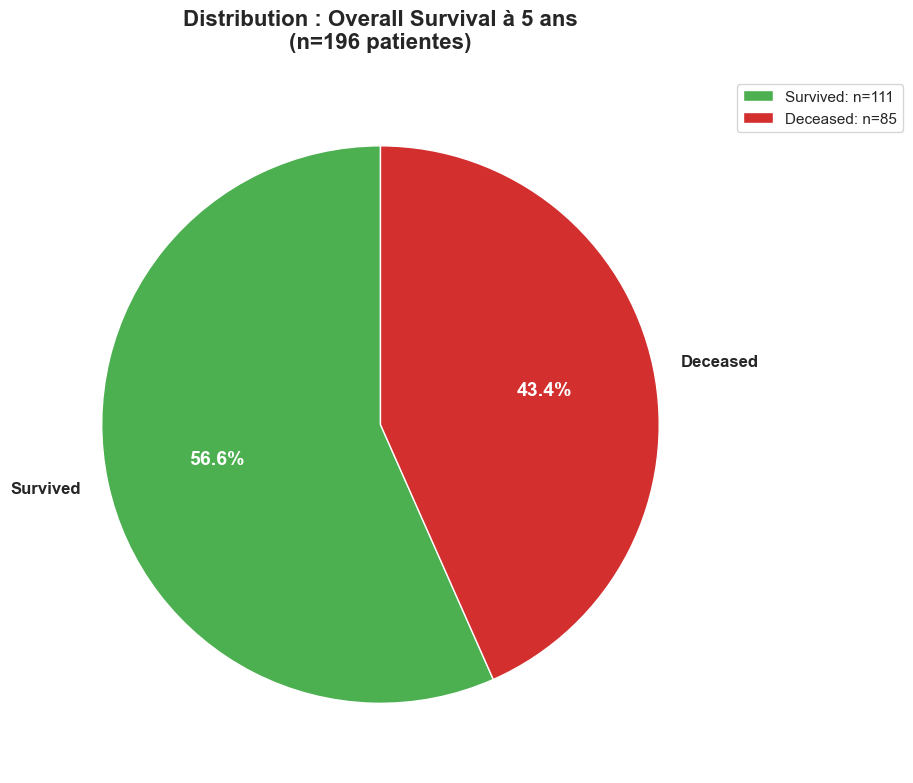

✅ Graphique sauvegardé : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\survival_analysis/target_distribution.png


In [41]:
labels = ['Survived', 'Deceased']
colors = ['#4caf50', '#d32f2f']
ordered_counts = [final_counts.get(label, 0) for label in labels]

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(
    ordered_counts, 
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)

ax.set_title(f"Distribution : Overall Survival à 5 ans\n(n={n_total} patientes)", 
             fontsize=16, weight='bold', pad=20)

legend_labels = [f'{label}: n={count}' for label, count in zip(labels, ordered_counts)]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(DIRS['SURVIVAL'], 'target_distribution.png'), bbox_inches='tight')
plt.show()

print(f"✅ Graphique sauvegardé : {DIRS['SURVIVAL']}/target_distribution.png")

### 5. Signal Transcriptomique : Séparabilité Survived vs Deceased

**Objectif** : Évaluer si les profils d'expression génique permettent de distinguer les deux classes.

**Méthodes** :
- **PCA** : Réduction linéaire pour capturer la variance principale.
- **t-SNE** : Réduction non-linéaire pour révéler les structures locales.
- **UMAP** : Préserve mieux la structure globale et locale que t-SNE.

**Interprétation** :
- Si séparation nette → Signal fort → MLP simple devrait bien performer.
- Si mélange → Signal faible/subtil → Autoencodeur nécessaire pour capturer les patterns complexes.

In [42]:
X = pd.read_csv(os.path.join(DIRS['PROCESSED'], 'X_survival5_196.csv.gz'), 
                index_col=0, compression='gzip').values
y = pd.read_csv(os.path.join(DIRS['PROCESSED'], 'y_survival5_196.csv.gz'), 
                index_col=0, compression='gzip')

y_labels = y['clinical_evolution'].map({'Survived': 0, 'Deceased': 1}).values

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

perplexity = min(30, len(X) // 4)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
X_tsne = tsne.fit_transform(X)

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X)

print(f"✅ Réductions de dimension terminées (n={len(X)} patientes)")
print(f"   PCA : {pca.explained_variance_ratio_.sum():.1%} variance expliquée")
print(f"   t-SNE : perplexity={perplexity}")
print(f"   UMAP : n_neighbors={reducer.n_neighbors}, min_dist={reducer.min_dist}")

✅ Réductions de dimension terminées (n=196 patientes)
   PCA : 17.3% variance expliquée
   t-SNE : perplexity=30
   UMAP : n_neighbors=15, min_dist=0.1


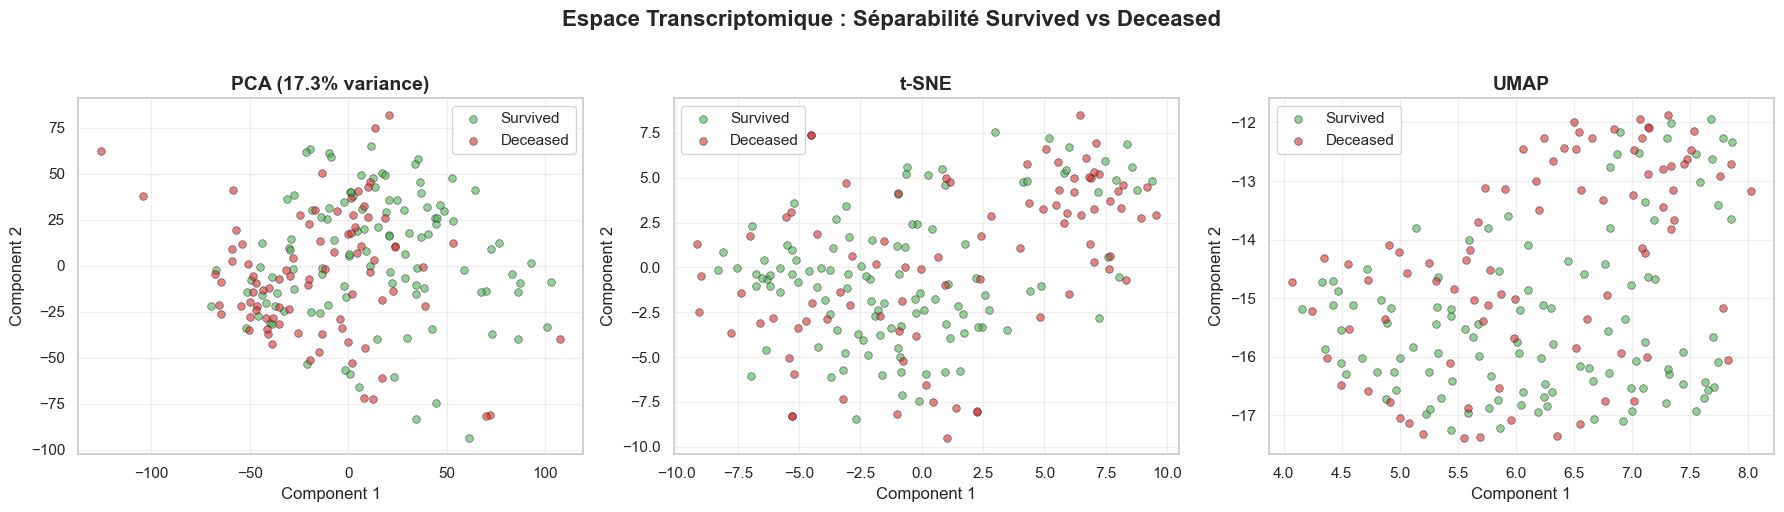

✅ Graphique sauvegardé : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\survival_analysis/transcriptomic_separability.png


In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [
    (X_pca, f"PCA ({pca.explained_variance_ratio_.sum():.1%} variance)"),
    (X_tsne, "t-SNE"),
    (X_umap, "UMAP")
]

for ax, (coords, title) in zip(axes, methods):
    for label, color, name in [(0, '#4caf50', 'Survived'), (1, '#d32f2f', 'Deceased')]:
        mask = y_labels == label
        ax.scatter(coords[mask, 0], coords[mask, 1], 
                   c=color, label=name, alpha=0.6, s=30, edgecolors='k', linewidths=0.5)
    
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend(loc='best', frameon=True)
    ax.grid(True, alpha=0.3)

plt.suptitle('Espace Transcriptomique : Séparabilité Survived vs Deceased', 
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(DIRS['SURVIVAL'], 'transcriptomic_separability.png'), bbox_inches='tight')
plt.show()

print(f"✅ Graphique sauvegardé : {DIRS['SURVIVAL']}/transcriptomic_separability.png")

**Interprétation** : L'analyse exploratoire révèle une **absence de séparation claire** entre les profils transcriptomiques des patientes Survived et Deceased dans les projections 2D (PCA, t-SNE, UMAP). Cette observation indique que :

1. Les biomarqueurs de survie ne dominent pas la variance principale du dataset (PCA 17.3% sur PC1-2).
2. Les signatures pronostiques sont probablement **distribuées sur de nombreux gènes** avec des interactions complexes.
3. L'approche par **apprentissage profond** (MLP + Autoencoder) est justifiée pour capturer ces patterns subtils inaccessibles aux méthodes de réduction classiques.

→ Cette complexité biologique motive la suite du pipeline : feature selection ciblée et extraction de représentations latentes via autoencodeur.

---

## BIFURCATION : Pipeline Supervisé vs Non-Supervisé

Le preprocessing diverge ici selon l'objectif :
- **Pipeline Supervisé (Section 6)** : Sélection ciblée sur n=196 avec cible définie → MLP
- **Pipeline Non-Supervisé (Section 7)** : Sélection large sur n=553 sans cible → Autoencoder

---

### 6. Feature Selection & Export : Pipeline Supervisé (n=196)

#### 6.1. Sélection des gènes (Mann-Whitney)

**Objectif** : Identifier les gènes les plus discriminants entre Survived et Deceased.

**Méthode** : Test de Mann-Whitney U (non-paramétrique) pour chaque gène.
- **Hypothèse nulle** : Les distributions d'expression sont identiques entre les deux groupes.
- **Seuil** : p-value < 0.01.

**Paramètre** : Sélection des top 1000 gènes par p-value pour le pipeline supervisé (ratio p/n = 5.1 avec n=196).

In [44]:
survived_mask = df_clin_clean['clinical_evolution'] == 'Survived'
deceased_mask = df_clin_clean['clinical_evolution'] == 'Deceased'

p_values = []
fold_changes = []

for gene in df_expr_clean.columns:
    survived_vals = df_expr_clean.loc[survived_mask, gene]
    deceased_vals = df_expr_clean.loc[deceased_mask, gene]
    
    stat, p_val = mannwhitneyu(survived_vals, deceased_vals, alternative='two-sided')
    fc = deceased_vals.mean() - survived_vals.mean()
    
    p_values.append(p_val)
    fold_changes.append(fc)

df_stats = pd.DataFrame({
    'gene': df_expr_clean.columns,
    'p_value': p_values,
    'fold_change': fold_changes
})

df_stats = df_stats.sort_values('p_value')

print(f"\n✅ Tests différentiels terminés : {len(df_stats)} gènes testés")
print(f"   Gènes significatifs (p < 0.01) : {(df_stats['p_value'] < 0.01).sum()}")
print(f"   Gènes significatifs (p < 0.001) : {(df_stats['p_value'] < 0.001).sum()}")


✅ Tests différentiels terminés : 21168 gènes testés
   Gènes significatifs (p < 0.01) : 3623
   Gènes significatifs (p < 0.001) : 1336


In [46]:
N_FEATURES_SUPERVISED = 1000
top_genes_supervised = df_stats.head(N_FEATURES_SUPERVISED)['gene'].values

print(f"\n✅ Sélection : {N_FEATURES_SUPERVISED} gènes les plus discriminants")
print(f"-> p-value     : \"Y a-t-il une différence ?\" (significativité statistique)")
print(f"-> Fold change : \"Quelle est l'amplitude de la différence ?\" (pertinence biologique)")
print(f"\nTop 20 gènes :")
print(df_stats[['gene', 'p_value', 'fold_change']].head(20).to_string(index=False))


✅ Sélection : 1000 gènes les plus discriminants
-> p-value     : "Y a-t-il une différence ?" (significativité statistique)
-> Fold change : "Quelle est l'amplitude de la différence ?" (pertinence biologique)

Top 20 gènes :
      gene      p_value  fold_change
     P2RX4 1.023073e-09    -0.594856
     TRBC2 1.417382e-08    -1.278463
    MBOAT2 4.359659e-08     1.067889
     CAMKV 5.542034e-08     0.500086
       GGH 1.108786e-07     0.787866
    MGAT4A 1.188711e-07     0.909321
      XPO5 1.222218e-07     0.448296
      HEXA 1.726377e-07    -0.540327
AC083899.1 2.363839e-07     0.341978
  TNFRSF14 2.744043e-07    -0.797692
AC092969.1 3.140678e-07     0.909057
      JPH1 3.591739e-07     0.738872
      NOL4 4.192479e-07     0.539292
     CMSS1 4.506469e-07     0.489392
  SLC25A35 4.689667e-07    -1.311549
    RANGRF 4.689667e-07    -0.717932
      BATF 6.783978e-07    -0.862911
     CLCN4 8.144388e-07     0.897852
   SCGB2A1 8.144388e-07    -2.085205
     IGSF1 8.773391e-07     1.02287

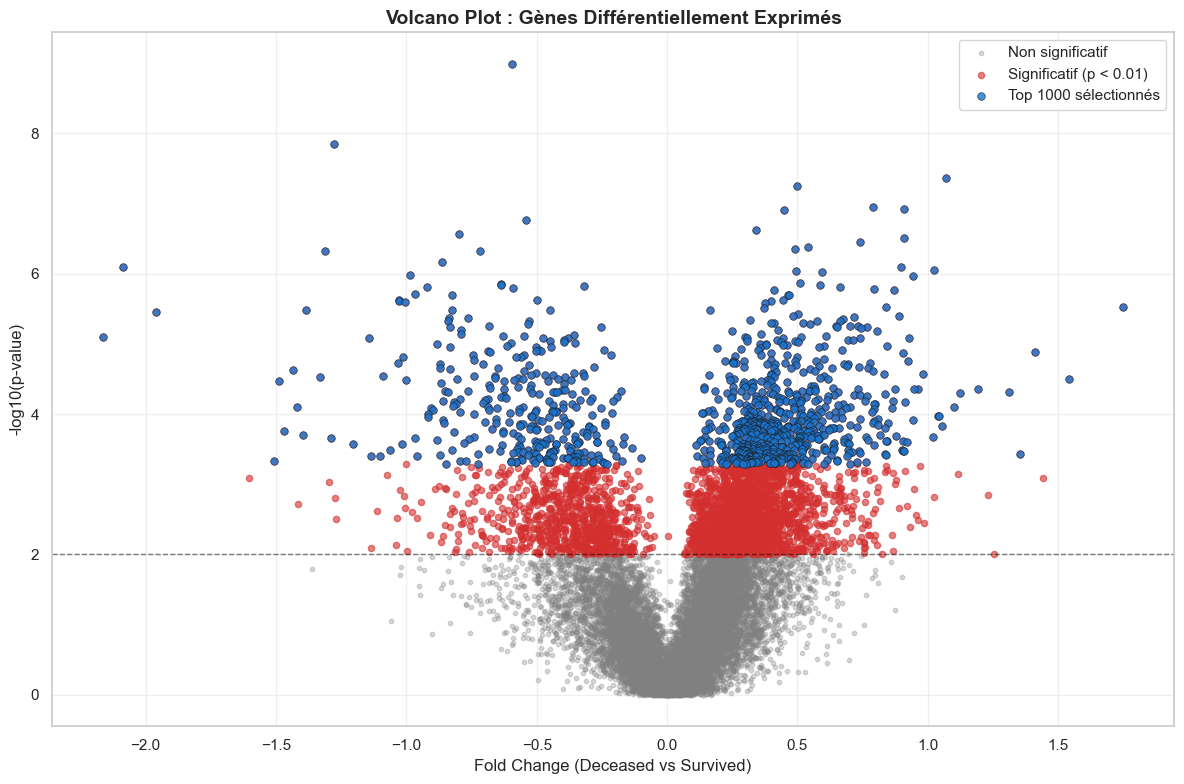

✅ Graphique sauvegardé : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/volcano_plot.png


In [47]:
df_stats['-log10_p'] = -np.log10(df_stats['p_value'] + 1e-300)

fig, ax = plt.subplots(figsize=(12, 8))

non_sig = df_stats[df_stats['p_value'] >= 0.01]
ax.scatter(non_sig['fold_change'], non_sig['-log10_p'], 
           c='gray', alpha=0.3, s=10, label='Non significatif')

sig = df_stats[df_stats['p_value'] < 0.01]
ax.scatter(sig['fold_change'], sig['-log10_p'], 
           c='#d32f2f', alpha=0.6, s=20, label='Significatif (p < 0.01)')

top_df = df_stats[df_stats['gene'].isin(top_genes_supervised)]
ax.scatter(top_df['fold_change'], top_df['-log10_p'], 
           c='#1976d2', alpha=0.8, s=30, edgecolors='k', linewidths=0.5,
           label=f'Top {N_FEATURES_SUPERVISED} sélectionnés')

ax.axhline(-np.log10(0.01), color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Fold Change (Deceased vs Survived)', fontsize=12)
ax.set_ylabel('-log10(p-value)', fontsize=12)
ax.set_title('Volcano Plot : Gènes Différentiellement Exprimés', fontsize=14, weight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DIRS['FEATURES'], 'volcano_plot.png'), bbox_inches='tight')
plt.show()

print(f"✅ Graphique sauvegardé : {DIRS['FEATURES']}/volcano_plot.png")

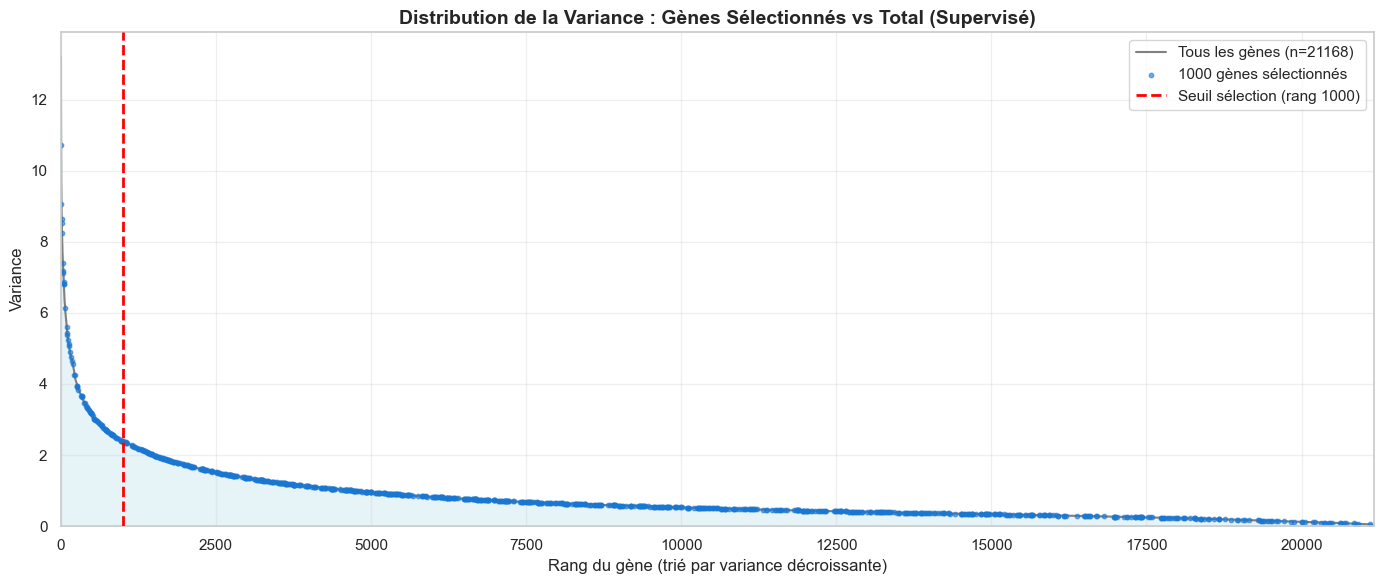

Variance totale : 16345.9
Variance sélectionnée : 1054.2
Couverture : 6.4%


In [48]:
df_expr_selected_supervised = df_expr_clean[top_genes_supervised]

variances_all = df_expr_clean.var(axis=0).sort_values(ascending=False)
selected_indices = [variances_all.index.get_loc(g) for g in top_genes_supervised]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(range(1, len(variances_all) + 1), variances_all.values, 
        color='gray', linewidth=1.5, label='Tous les gènes (n=21168)', zorder=1)

ax.fill_between(range(1, len(variances_all) + 1), variances_all.values, 
                alpha=0.3, color='lightblue', zorder=0)

ax.scatter([i+1 for i in selected_indices], 
           [variances_all.iloc[i] for i in selected_indices],
           color='#1976d2', s=10, alpha=0.6, label=f'{N_FEATURES_SUPERVISED} gènes sélectionnés', zorder=2)

ax.axvline(N_FEATURES_SUPERVISED, color='red', linestyle='--', linewidth=2, 
           label=f'Seuil sélection (rang {N_FEATURES_SUPERVISED})', zorder=3)

ax.set_xlabel('Rang du gène (trié par variance décroissante)', fontsize=12)
ax.set_ylabel('Variance', fontsize=12)
ax.set_title('Distribution de la Variance : Gènes Sélectionnés vs Total (Supervisé)', 
             fontsize=14, weight='bold')
ax.set_xlim(0, len(variances_all))
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"Variance totale : {variances_all.sum():.1f}")
print(f"Variance sélectionnée : {variances_all[top_genes_supervised].sum():.1f}")
print(f"Couverture : {variances_all[top_genes_supervised].sum() / variances_all.sum() * 100:.1f}%")

#### 6.2. Export datasets supervisés

In [49]:
SUPERVISED_DIR = os.path.join(DIRS['ML_READY'], 'supervised')
os.makedirs(SUPERVISED_DIR, exist_ok=True)

df_expr_selected_supervised.to_csv(os.path.join(SUPERVISED_DIR, 'X_selected_1000.csv.gz'), compression='gzip')

df_clin_clean[['clinical_evolution']].to_csv(os.path.join(SUPERVISED_DIR, 'y_survival_5y.csv.gz'), compression='gzip')

with open(os.path.join(SUPERVISED_DIR, 'selected_genes_1000.txt'), 'w') as f:
    f.write('\n'.join(top_genes_supervised))

df_stats.to_csv(os.path.join(DIRS['FEATURES'], 'differential_expression_stats.csv.gz'), 
                compression='gzip', index=False)

print("\n" + "="*60)
print("EXPORT TERMINÉ - PIPELINE SUPERVISÉ")
print("="*60)
print(f"\nRépertoire : {SUPERVISED_DIR}/")
print(f"  - X_selected_1000.csv.gz      : {df_expr_selected_supervised.shape}")
print(f"  - y_survival_5y.csv.gz        : {df_clin_clean[['clinical_evolution']].shape}")
print(f"  - selected_genes_1000.txt     : {len(top_genes_supervised)} gènes")
print(f"\nRépertoire : {DIRS['FEATURES']}/")
print(f"  - differential_expression_stats.csv.gz")


EXPORT TERMINÉ - PIPELINE SUPERVISÉ

Répertoire : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready\supervised/
  - X_selected_1000.csv.gz      : (196, 1000)
  - y_survival_5y.csv.gz        : (196, 1)
  - selected_genes_1000.txt     : 1000 gènes

Répertoire : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/
  - differential_expression_stats.csv.gz


---

### 7. Feature Selection & Export : Pipeline Non-Supervisé (n=553)

#### 7.1. Sélection des gènes (Variance-based)

**Objectif** : Sélectionner les gènes les plus variables pour l'autoencoder.

**Méthode** : Sélection basée sur la variance (pas de cible, n=553 patientes incluant censurées).

**Paramètre** : Top 3000 gènes pour permettre à l'autoencoder de découvrir des patterns complexes sur la cohorte complète.

In [50]:
N_FEATURES_UNSUPERVISED = 3000

variances_full = df_expr.var(axis=0).sort_values(ascending=False)
top_genes_unsupervised = variances_full.head(N_FEATURES_UNSUPERVISED).index.values

df_expr_selected_unsupervised = df_expr[top_genes_unsupervised]

print(f"\n✅ Sélection variance-based : {N_FEATURES_UNSUPERVISED} gènes")
print(f"   Cohorte complète : n={df_expr.shape[0]} patientes")
print(f"   Variance médiane : {variances_full[top_genes_unsupervised].median():.3f}")


✅ Sélection variance-based : 3000 gènes
   Cohorte complète : n=553 patientes
   Variance médiane : 2.028


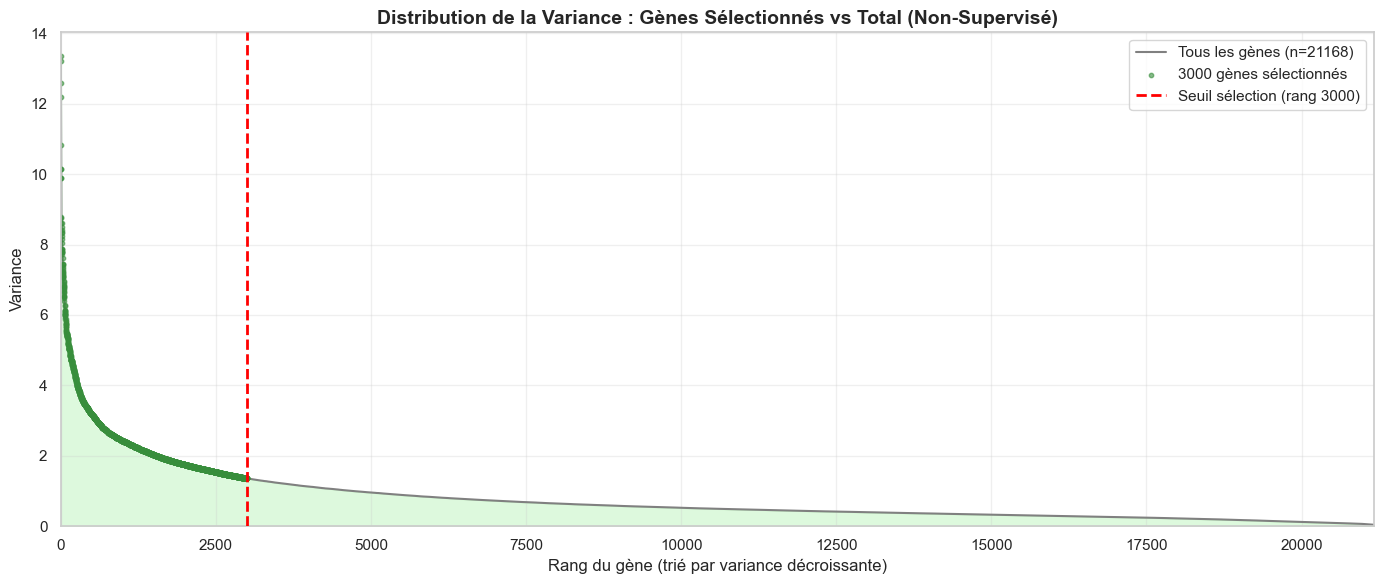

Variance totale : 16351.6
Variance sélectionnée : 7251.7
Couverture : 44.3%


In [51]:
selected_indices_unsup = [variances_full.index.get_loc(g) for g in top_genes_unsupervised]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(range(1, len(variances_full) + 1), variances_full.values, 
        color='gray', linewidth=1.5, label='Tous les gènes (n=21168)', zorder=1)

ax.fill_between(range(1, len(variances_full) + 1), variances_full.values, 
                alpha=0.3, color='lightgreen', zorder=0)

ax.scatter([i+1 for i in selected_indices_unsup], 
           [variances_full.iloc[i] for i in selected_indices_unsup],
           color='#388e3c', s=10, alpha=0.6, label=f'{N_FEATURES_UNSUPERVISED} gènes sélectionnés', zorder=2)

ax.axvline(N_FEATURES_UNSUPERVISED, color='red', linestyle='--', linewidth=2, 
           label=f'Seuil sélection (rang {N_FEATURES_UNSUPERVISED})', zorder=3)

ax.set_xlabel('Rang du gène (trié par variance décroissante)', fontsize=12)
ax.set_ylabel('Variance', fontsize=12)
ax.set_title('Distribution de la Variance : Gènes Sélectionnés vs Total (Non-Supervisé)', 
             fontsize=14, weight='bold')
ax.set_xlim(0, len(variances_full))
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"Variance totale : {variances_full.sum():.1f}")
print(f"Variance sélectionnée : {variances_full[top_genes_unsupervised].sum():.1f}")
print(f"Couverture : {variances_full[top_genes_unsupervised].sum() / variances_full.sum() * 100:.1f}%")

#### 7.2. Export datasets non-supervisés

In [52]:
UNSUPERVISED_DIR = os.path.join(DIRS['ML_READY'], 'unsupervised')
os.makedirs(UNSUPERVISED_DIR, exist_ok=True)

df_expr_selected_unsupervised.to_csv(os.path.join(UNSUPERVISED_DIR, 'X_reduced_3000.csv.gz'), compression='gzip')

with open(os.path.join(UNSUPERVISED_DIR, 'selected_genes_3000.txt'), 'w') as f:
    f.write('\n'.join(top_genes_unsupervised))

print("\n" + "="*60)
print("EXPORT TERMINÉ - PIPELINE NON-SUPERVISÉ")
print("="*60)
print(f"\nRépertoire : {UNSUPERVISED_DIR}/")
print(f"  - X_reduced_3000.csv.gz       : {df_expr_selected_unsupervised.shape}")
print(f"  - selected_genes_3000.txt     : {len(top_genes_unsupervised)} gènes")


EXPORT TERMINÉ - PIPELINE NON-SUPERVISÉ

Répertoire : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready\unsupervised/
  - X_reduced_3000.csv.gz       : (553, 3000)
  - selected_genes_3000.txt     : 3000 gènes


---

### 8. Summary Report

In [53]:
print("\n" + "="*60)
print("PIPELINE 0C (ML PREPROCESSING) - STATUS REPORT")
print("="*60)

print("\n✅ SUMMARY :")
print("  - Target Engineering : Overall Survival à 5 ans")
print("  - Deux pipelines parallèles créés :")
print(f"    • Supervisé : {N_FEATURES_SUPERVISED} gènes (n=196 patientes)")
print(f"    • Non-supervisé : {N_FEATURES_UNSUPERVISED} gènes (n=553 patientes)")

print(f"\n✅ DATASET SUPERVISÉ (n=196) :")
survived_count = final_counts.get('Survived', 0)
deceased_count = final_counts.get('Deceased', 0)
print(f"  - Survived : n={survived_count} ({survived_count/n_total*100:.1f}%)")
print(f"  - Deceased : n={deceased_count} ({deceased_count/n_total*100:.1f}%)")
print(f"  - Features : {N_FEATURES_SUPERVISED} gènes (Mann-Whitney)")

print(f"\n✅ DATASET NON-SUPERVISÉ (n=553) :")
print(f"  - Total patientes : n={df_expr.shape[0]}")
print(f"  - Features : {N_FEATURES_UNSUPERVISED} gènes (variance-based)")

print(f"\n✅ OUTPUTS LOCATION :")
print(f"  - Supervisé      : {SUPERVISED_DIR}/")
print(f"  - Non-supervisé  : {UNSUPERVISED_DIR}/")
print(f"  - Visualizations : {DIRS['SURVIVAL']}/")
print(f"  - Feature stats  : {DIRS['FEATURES']}/")

print(f"\n✅ NEXT STEPS :")
print("  - 0D : Supervised Learning (MLP sur X_selected_1000 → y_survival_5y)")
print("  - 0E : Unsupervised Learning (Autoencoder sur X_reduced_3000)")
print("  - 0F : k-NN dans l'espace latent (approche originale du projet)")

print(f"\n🕒 Pipeline exécuté le : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)


PIPELINE 0C (ML PREPROCESSING) - STATUS REPORT

✅ SUMMARY :
  - Target Engineering : Overall Survival à 5 ans
  - Deux pipelines parallèles créés :
    • Supervisé : 1000 gènes (n=196 patientes)
    • Non-supervisé : 3000 gènes (n=553 patientes)

✅ DATASET SUPERVISÉ (n=196) :
  - Survived : n=111 (56.6%)
  - Deceased : n=85 (43.4%)
  - Features : 1000 gènes (Mann-Whitney)

✅ DATASET NON-SUPERVISÉ (n=553) :
  - Total patientes : n=553
  - Features : 3000 gènes (variance-based)

✅ OUTPUTS LOCATION :
  - Supervisé      : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready\supervised/
  - Non-supervisé  : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready\unsupervised/
  - Visualizations : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\survival_analysis/
  - Feature stats  : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/

✅ NEXT STEPS :
  - 0D : Supervised Learning (MLP sur X_selected_1000 → y_survival_5y)
  - 0E : Unsupervised Learning (Autoencoder sur X_reduced_3